In [2]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from codonUtils import utils
from codonoptimizer import MonteCarlo
from codonTable import codonTable
import bct
import pickle
%load_ext autoreload

In [2]:
help(MonteCarlo)

Help on class MonteCarlo in module codonoptimizer:

class MonteCarlo(builtins.object)
 |  MonteCarlo: A class designed to optimize a codon table given an
 |  arbitrary objective function to minimize/maximize
 |  
 |  Methods defined here:
 |  
 |  GDA(self, dW=None, W=0, W_stop=inf, maxIter=1000, preserveBlock=False, preserveStop=False, subFunc='minPRS')
 |      The Great Deluge Algorithm for optimizing an objective function over
 |      codon table space
 |      
 |      Parameters
 |      ----------
 |      - float dW=None: represents the rate of change (rain flux) of min
 |          allowable energy (water level); if None, initialized to 1% of
 |          cost(self.table)
 |      - float W=0: represents the initial minimal acceptable energy level
 |          (water level); defaults to 0
 |      - float W_stop=inf: represents the maximum allowable water level; stops
 |          algorithm when W > W_stop; defaults to an infinte value
 |      - int maxIter=1000: represents the maximum 

## Gathering Statistics

A set of adjacency matrices that preserve the degree, weight and strength distributions of the Standard Codon table graph were generated using bct.null_model_dir_sign() and used as a null model. A set of evolved tables were also generated and the densities of the resulting sets were compared.

In [4]:
%autoreload 2
# define number of trials to run
N = 1000
sim = MonteCarlo()
# preallocate memory for statistics
densities = np.zeros(N)
efficiencies = np.zeros(N)
clustCoeff = np.zeros(N)
modularities = np.zeros(N)
assortativities = np.zeros(N)
# perform N trials
for i in range(N):
    # generage graph
    ct, *dummy = sim.GDA(subFunc='SCV')
    ct = codonTable(ct)
    Cij = ct.adjMat
    # calculate statistics
    densities[i], *dummy = bct.density_und(Cij)
    efficiencies[i] = bct.efficiency_wei(Cij)
    clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, modularities[i] = bct.modularity_und(Cij)
    assortativities[i] = bct.assortativity_wei(Cij, 0)

In [5]:
# pickle resulting statistics so they don't have to be re calculated
stats = [densities, efficiencies, clustCoeff, modularities, assortativities]
with open('res/SCV.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

In [13]:
## Null Models
%autoreload 2
# define number of adjMats to generate
N = 10000
# get standard table
ct = codonTable()
C_st = ct.adjMat
# preallocate memory for statistics
null_densities = np.zeros(N)
null_efficiencies = np.zeros(N)
null_clustCoeff = np.zeros(N)
null_modularities = np.zeros(N)
null_assortativities = np.zeros(N)
# perform N trials
for i in range(N):
    # generate new null graph
    Cij, *dummy = bct.null_model_und_sign(C_st)
    # calculate statistics
    null_densities[i], *dummy = bct.density_und(Cij)
    null_efficiencies[i] = bct.efficiency_wei(Cij)
    null_clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, null_modularities[i] = bct.modularity_und(Cij)
    null_assortativities[i] = bct.assortativity_wei(Cij, 0)

/home/jon/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1024: RuntimeWarning: divide by zero encountered in double_scalars
  f = 1 - Wv[r] / S[j[o]]
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1025: RuntimeWarning: invalid value encountered in multiply
  P[j[o], :] *= f
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1026: RuntimeWarning: invalid value encountered in multiply
  P[:, j[o]] *= f
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1021: RuntimeWarning: divide by zero encountered in double_scalars
  f = 1 - Wv[r] / S[i[o]]
/home/jon/Dropbox/Lab/Arbitrary Translat

In [15]:
# pickle resulting statistics so they don't have to be re calculated
stats = [null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities]
with open('res/null.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

In [19]:
## Visualize the data!!

# unpickle data
with open('res/minPRS.pickle', 'rb') as handle:
    PRS_densities, PRS_efficiencies, PRS_clustCoeff, PRS_modularities, PRS_assortativities  = pickle.load(handle)

with open('res/Gilis.pickle', 'rb') as handle:
    Gilis_densities, Gilis_efficiencies, Gilis_clustCoeff, Gilis_modularities, Gilis_assortativities  = pickle.load(handle)

with open('res/SCV.pickle', 'rb') as handle:
    SCV_densities, SCV_efficiencies, SCV_clustCoeff, SCV_modularities, SCV_assortativities  = pickle.load(handle)

with open('res/null.pickle', 'rb') as handle:
    null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities  = pickle.load(handle)

## Densities

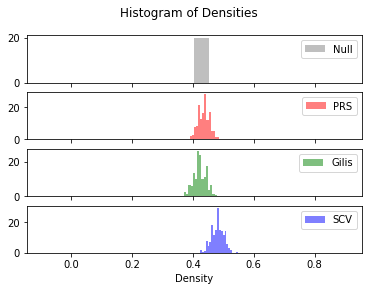

In [53]:
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].hist(null_densities, 20, color='grey', alpha=0.5, normed=True, label='Null')
axarr[1].hist(PRS_densities, 20, color='red', alpha=0.5, normed=True, label='PRS')
axarr[2].hist(Gilis_densities, 20, color='green', alpha=0.5, normed=True, label='Gilis')
axarr[3].hist(SCV_densities, 20, color='blue', alpha=0.5, normed=True, label='SCV')
fig.suptitle('Histogram of Densities')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
plt.xlabel('Density')
plt.show()

## Efficiencies

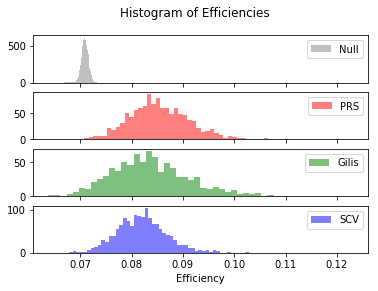

In [51]:
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].hist(null_efficiencies, 50, color='grey', alpha=0.5, normed=True, label='Null')
axarr[1].hist(PRS_efficiencies, 50, color='red', alpha=0.5, normed=True, label='PRS')
axarr[2].hist(Gilis_efficiencies, 50, color='green', alpha=0.5, normed=True, label='Gilis')
axarr[3].hist(SCV_efficiencies, 50, color='blue', alpha=0.5, normed=True, label='SCV')
fig.suptitle('Histogram of Efficiencies')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
plt.xlabel('Efficiency')
plt.show()

## Clustering Coefficients

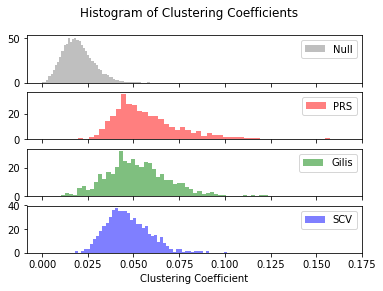

In [55]:
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].hist(null_clustCoeff, 50, color='grey', alpha=0.5, normed=True, label='Null')
axarr[1].hist(PRS_clustCoeff, 50, color='red', alpha=0.5, normed=True, label='PRS')
axarr[2].hist(Gilis_clustCoeff, 50, color='green', alpha=0.5, normed=True, label='Gilis')
axarr[3].hist(SCV_clustCoeff, 50, color='blue', alpha=0.5, normed=True, label='SCV')

fig.suptitle('Histogram of Clustering Coefficients')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
plt.xlabel('Clustering Coefficient')
plt.show()

## Modularities

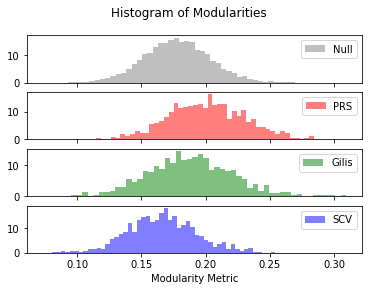

In [56]:
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].hist(null_modularities, 50, color='grey', alpha=0.5, normed=True, label='Null')
axarr[1].hist(PRS_modularities, 50, color='red', alpha=0.5, normed=True, label='PRS')
axarr[2].hist(Gilis_modularities, 50, color='green', alpha=0.5, normed=True, label='Gilis')
axarr[3].hist(SCV_modularities, 50, color='blue', alpha=0.5, normed=True, label='SCV')

fig.suptitle('Histogram of Modularities')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
plt.xlabel('Modularity Metric')
plt.show()

## Assortativities

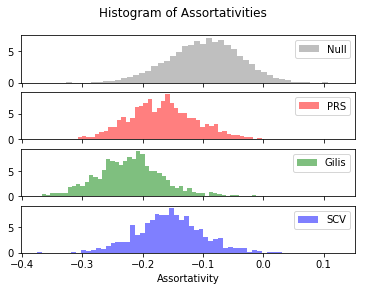

In [58]:
fig, axarr = plt.subplots(4, sharex=True)
axarr[0].hist(null_assortativities, 50, color='grey', alpha=0.5, normed=True, label='Null')
axarr[1].hist(PRS_assortativities, 50, color='red', alpha=0.5, normed=True, label='PRS')
axarr[2].hist(Gilis_assortativities, 50, color='green', alpha=0.5, normed=True, label='Gilis')
axarr[3].hist(SCV_assortativities, 50, color='blue', alpha=0.5, normed=True, label='SCV')

fig.suptitle('Histogram of Assortativities')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
plt.xlabel('Assortativity')
plt.show()